Project title: Investigation of the impact of planetary alignments, lunar phases, and economic growth rate on birth rates in the United States.

Overview:

As part of the skills pathway offered by Codecademy.org, this project involved an in-depth analysis to explore possible correlations between planetary alignments, lunar phases, and birth rates in the United States. Throughout the project, I was assisted by ChatGPT, an OpenAI AI language model, which provided guidance and analytical support.

Key steps and methodologies:

Data collection: The project began with the collection of planetary position data from NASA's JPL Horizons system, birth rate data from relevant U.S. databases from the Kaggle website, and finally economic growth data from S&P Global Market Intelligence's Monthly GDP Index. Moon phases were calculated using proprietary Python functions.

Planetary alignment analysis: planetary positions were analyzed to identify cases of alignment within a specified angular threshold. This analysis aimed to investigate whether planetary alignments have any correlation with changes in birth rates.

Consideration of lunar phases: The impact of lunar phases on birth rates was examined. The data were segmented into four groups based on the lunar cycle: new moon, first quarter, full moon, and last quarter. This division was intended to isolate the study by lunar phases.

Adjusting the data for birth rates: To focus on unscheduled spontaneous births, the difference between the mean number of weekday births (containing scheduled deliveries) and the mean number of unscheduled spontaneous weekend births was subtracted from the weekday data (the difference to be subtracted is approximately 4,300). This adjustment was made to account for the small number of unscheduled births.

Inclusion of economic data: Later in the study, economic growth data, specifically the U.S. GDP growth rate, was introduced as an additional variable. This inclusion was intended to explore the possible influence of economic factors on birth rates.

Model development: A machine learning model was developed with the scikit-learn devel

was developed using the Python scikit-learn library. The model combined Principal Component Analysis (PCA) and Linear Regression to predict birth rates as a function of planetary alignments, lunar phases and GDP growth rate. PCA was used to reduce the dimensionality of the data set and identify the most significant features.

Data normalization and model training: Before training the model, data normalization techniques were applied to ensure that the model accurately captured the underlying patterns in the data. The model was then trained with the fitted dataset, which reflected spontaneous birth rates, planetary alignments, lunar phases, and economic indicators.

Analysis and interpretation: The final step involved analyzing the model performance and interpreting the results. This included assessing the accuracy of the model and determining the importance of different features, such as the impact of lunar phases and planetary alignments on birth rates.

Throughout the project, ChatGPT provided assistance with coding, data analysis, and interpretation of the results, demonstrating the potential of AI to support data science projects.

Conclusions:

This project showed the intricate process of data analysis and model building in exploring complex relationships between astronomical events and human activities. It highlighted the importance of data preprocessing, feature engineering and the careful application of machine learning techniques to draw meaningful conclusions from the data.
As a relevant fact found, it was verified that there is no correlation between the alignment of planets or lunar phases in the variation of births... so any opinion that, for example, there are more births when there is a full moon,  is a full-fledged myth..


In [ ]:
#First, let's import the necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import requests
import re
from astropy.coordinates import Angle
from astropy import units as u
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

In [3]:
#Secondly, we can read a csv with the births from 2000 until 2014 of US downloaded from Kaggle (https://www.kaggle.com/datasets/mysarahmadbhat/us-births-2000-to-2014)
df_birth = pd.read_csv('./US_births_2000-2014_SSA.csv')

#Now we can improve our own dataset of the moon phases creating a function
# Function to calculate the phases of the moon
def get_moon_phase(date):
    """
    Calculate the moon phase for a given date.
    Returns the moon phase as a string.
    """
    # Difference between the given date and the reference date (2000-01-06)
    diff = date - datetime(2000, 1, 6)
    days = diff.days
    
    # Calculate the lunar phase using a 29.53 day synodic cycle.
    lunations = (days / 29.53058867)
    position = lunations % 1

    # Determines the simplified moon phase
    if position < 0.125:
        return "New Moon"
    elif 0.125 <= position < 0.375:
        return "First Quarter"
    elif 0.375 <= position < 0.625:
        return "Full Moon"
    elif 0.625 <= position < 0.875:
        return "Last Quarter"
    else:
        return "New Moon"

# Create a DataFrame with dates and moon phases for the period 2000-2014.
start_date = datetime(2000, 1, 1)
end_date = datetime(2014, 12, 31)
date_range = pd.date_range(start_date, end_date)

moon_phases = pd.DataFrame({
    'Date': date_range,
    'Moon_Phase': [get_moon_phase(date) for date in date_range]
})


# Now we can create the dataset of the planet ubications thanks to the awesome NASA API!
# NASA API's URL from Horizons
url = "https://ssd.jpl.nasa.gov/api/horizons.api"

# List of planet IDs for the Horizons API:
# [id:199]   Mercury
# [id:299]   Venus
# [id:399]   Earth
# [id:499]   Mars
# [id:599]   Jupiter
# [id:699]   Saturn
# [id:799]   Uranus
# [id:899]   Neptune
#creamos la lista para iterar
planet_ids = ['199', '299', '399', '499', '599', '699', '799', '899']

# IMPORTANT: the maximum query is about 6 years if you are quering the data per day and per hour..
# Application parameters first part 
params_common_1 = {
    "format": "text",
    "OBJ_DATA": "YES",
    "MAKE_EPHEM": "YES",
    "EPHEM_TYPE": "OBSERVER",
    "CENTER": "'500@399'",  # Geocentric
    "START_TIME": "'2000-01-01'",
    "STOP_TIME": "'2006-12-31'",
    "STEP_SIZE": "'60 m'",
    "QUANTITIES": "'1,9,20,23,24,29'"
}
# Regular expression to extract position data
pattern = r'(\d{4}-\w{3}-\d{2} \d{2}:\d{2})\s+([\d ]+\.\d+)\s+([+-][\d ]+\.\d+)'

# DataFrame for storing the data of all planets
df_planets_all_1 = pd.DataFrame()

# Loop to iterate through the planet IDs and get the data.
for planet_id in planet_ids:
    params = params_common_1.copy()
    params["COMMAND"] = f"'{planet_id}'"
    
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        matches = re.findall(pattern, response.text)
        temp_df = pd.DataFrame(matches, columns=['Datetime', 'R.A.', 'DEC'])
        temp_df['Planet'] = planet_id
        df_planets_all_1 = pd.concat([df_planets_all_1, temp_df])
    else:
        print(f"Error in the query for planet ID {planet_id}: {response.status_code}")

# Convert the column 'Datetime' to datetime
df_planets_all_1['Datetime'] = pd.to_datetime(df_planets_all_1['Datetime'])

# Processing the DataFrame of planets
df_planets_all_1['Date'] = pd.to_datetime(df_planets_all_1['Datetime']).dt.date
df_planets_all_1['Time'] = pd.to_datetime(df_planets_all_1['Datetime']).dt.time

# Convert the column 'Date' to datetime
df_planets_all_1['Date'] = pd.to_datetime(df_planets_all_1['Date'])

# Application parameters second part 
params_common_2 = {
    "format": "text",
    "OBJ_DATA": "YES",
    "MAKE_EPHEM": "YES",
    "EPHEM_TYPE": "OBSERVER",
    "CENTER": "'500@399'",  # Geocentric
    "START_TIME": "'2007-01-01'",
    "STOP_TIME": "'2014-12-31'",
    "STEP_SIZE": "'60 m'",
    "QUANTITIES": "'1,9,20,23,24,29'"
}


# DataFrame to store the data of all planets

df_planets_all_2 = pd.DataFrame()

# Loop to iterate through the planet IDs and get the data.
for planet_id in planet_ids:
    params = params_common_2.copy()
    params["COMMAND"] = f"'{planet_id}'"
    
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        matches = re.findall(pattern, response.text)
        temp_df = pd.DataFrame(matches, columns=['Datetime', 'R.A.', 'DEC'])
        temp_df['Planet'] = planet_id
        df_planets_all_2 = pd.concat([df_planets_all_2, temp_df])
    else:
        print(f"Error in the query for planet ID {planet_id}: {response.status_code}")

# Convert column 'Datetime' to datetime
df_planets_all_2['Datetime'] = pd.to_datetime(df_planets_all_2['Datetime'])

# Processing the planets DataFrame
df_planets_all_2['Date'] = pd.to_datetime(df_planets_all_2['Datetime']).dt.date
df_planets_all_2['Time'] = pd.to_datetime(df_planets_all_2['Datetime']).dt.time
# Convert the column 'Date' to datetime
df_planets_all_2['Date'] = pd.to_datetime(df_planets_all_2['Date'])




# Let's parse de data of date and time in the dataframes to obtain a common datatype in all 3 dataframes
# Construction of a date string in the format 'YYYYY-MM-DD' and then convert it to datetime
df_birth['Date'] = pd.to_datetime(df_birth['year'].astype(str) + '-' + 
                                  df_birth['month'].astype(str).str.zfill(2) + '-' + 
                                  df_birth['date_of_month'].astype(str).str.zfill(2))

df_planets_all_1.to_csv('./df_planets_all_2000_2006.csv', index = False)
df_planets_all_2.to_csv('./df_planets_all_2007_2014.csv', index = False)

df_planets_all_1 = pd.read_csv('./df_planets_all_2000_2006.csv')
df_planets_all_2 = pd.read_csv('./df_planets_all_2007_2014.csv')

# Now let's concat both dataframes
df_planets_all = pd.concat([df_planets_all_1, df_planets_all_2])
df_planets_all.head()

,Datetime,R.A.,DEC,Planet,Date,Time
0,2000-01-01 00:00:00,18 04 55.46,-24 22 48.7,199,2000-01-01,00:00:00
1,2000-01-01 01:00:00,18 05 12.52,-24 23 01.5,199,2000-01-01,01:00:00
2,2000-01-01 02:00:00,18 05 29.59,-24 23 14.2,199,2000-01-01,02:00:00
3,2000-01-01 03:00:00,18 05 46.66,-24 23 26.7,199,2000-01-01,03:00:00
4,2000-01-01 04:00:00,18 06 03.74,-24 23 39.1,199,2000-01-01,04:00:00


In [4]:
# To get the alignements, we need tot ransform the data position in degrees, so we imporve the next function
#conversion to degrees

def convert_ra_to_decimal(ra):
    """
    Convert Right Ascension from 'HH MM SS' to decimal degrees.
    """
    try:
        ra_angle = Angle(ra, unit=u.hour)
        return ra_angle.degree
    except ValueError:
        return None

def convert_dec_to_decimal(dec):
    """
    Convert Declination from 'DD MM SS' to decimal degrees.
    """
    try:
        dec_angle = Angle(dec, unit=u.deg)
        return dec_angle.degree
    except ValueError:
        return None


# Applying conversions
df_planets_all['RA_decimal'] = df_planets_all['R.A.'].apply(convert_ra_to_decimal)
df_planets_all['DEC_decimal'] = df_planets_all['DEC'].apply(convert_dec_to_decimal)

print(df_planets_all.head())


              Datetime         R.A.          DEC  Planet        Date  \
0  2000-01-01 00:00:00  18 04 55.46  -24 22 48.7     199  2000-01-01   
1  2000-01-01 01:00:00  18 05 12.52  -24 23 01.5     199  2000-01-01   
2  2000-01-01 02:00:00  18 05 29.59  -24 23 14.2     199  2000-01-01   
3  2000-01-01 03:00:00  18 05 46.66  -24 23 26.7     199  2000-01-01   
4  2000-01-01 04:00:00  18 06 03.74  -24 23 39.1     199  2000-01-01   

       Time  RA_decimal  DEC_decimal  
0  00:00:00  271.231083   -24.380194  
1  01:00:00  271.302167   -24.383750  
2  02:00:00  271.373292   -24.387278  
3  03:00:00  271.444417   -24.390750  
4  04:00:00  271.515583   -24.394194  


In [6]:
# Then, to get the planet alignements we set a threshold and make a one-on-one comparision
# Set the angular threshold for the alignment (5 degrees in this example)
#IMPORTANT!!!!!  this cell will take very long time if you are using a normal computer (3 hours aprox. in my case..)
threshold = 5

# Create a DataFrame to store the alignments.
alignments = []

# Loop for each date in the DataFrame
for date in df_planets_all['Date'].unique():
    planets_on_date = df_planets_all[df_planets_all['Date'] == date]
    # Check alignments
    for i in range(len(planets_on_date)):
        for j in range(i + 1, len(planets_on_date)):
            planet1 = planets_on_date.iloc[i]
            planet2 = planets_on_date.iloc[j]
            if abs(planet1['RA_decimal'] - planet2['RA_decimal']) <= threshold and \
               abs(planet1['DEC_decimal'] - planet2['DEC_decimal']) <= threshold:
                alignments.append({'Date': date, 'Planets': [planet1['Planet'], planet2['Planet']]})

# Convert the list of alignments to a DataFrame
df_alignments = pd.DataFrame(alignments)

df_alignments
# Time to make some transformations on the dataframe
# Eliminate duplicate planet pairs (where a planet is compared to itself).
df_alignments = df_alignments[df_alignments['Planets'].apply(lambda x: x[0] != x[1])]

# Group by date and combine lists of aligned planets
df_alignments_grouped = df_alignments.groupby('Date')['Planets'].sum().reset_index()

# Remove duplicate planets within each alignment list
df_alignments_grouped['Planets'] = df_alignments_grouped['Planets'].apply(lambda x: list(set(x)))


In [7]:
df_alignments_grouped

,Date,Planets
0,2000-01-18,"[899, 199]"
1,2000-01-19,"[899, 199]"
2,2000-01-20,"[899, 199]"
3,2000-01-21,"[899, 199]"
4,2000-01-22,"[899, 199]"
...,...,...
2693,2014-12-27,"[299, 199]"
2694,2014-12-28,"[299, 199]"
2695,2014-12-29,"[299, 199]"
2696,2014-12-30,"[299, 199]"


In [8]:
df_alignments_grouped.to_csv('alignements.csv', index = False)

In [2]:
df_alignments_grouped = pd.read_csv('alignements.csv')
df_birth = pd.read_csv('./US_births_2000-2014_SSA.csv')
# Let's parse de data of date and time in the dataframes to obtain a common datatype in all 3 dataframes
# Construct a date string in the format 'YYYYY-MM-DD' and then convert it to datetime
df_birth['Date'] = pd.to_datetime(df_birth['year'].astype(str) + '-' + 
                                  df_birth['month'].astype(str).str.zfill(2) + '-' + 
                                  df_birth['date_of_month'].astype(str).str.zfill(2))

# Function to calculate the phases of the moon
def get_moon_phase(date):
    """
    Calculate the moon phase for a given date.
    Returns the moon phase as a string.
    """
    # Difference between the given date and the reference date (2000-01-06)
    diff = date - datetime(2000, 1, 6)
    days = diff.days
    
    # Calculate the lunar phase using a 29.53 day synodic cycle.
    lunations = (days / 29.53058867)
    position = lunations % 1

    # Determine the phase of the moon simplified
    if position < 0.125:
        return "New Moon"
    elif 0.125 <= position < 0.375:
        return "First Quarter"
    elif 0.375 <= position < 0.625:
        return "Full Moon"
    elif 0.625 <= position < 0.875:
        return "Last Quarter"
    else:
        return "New Moon"

# Create a DataFrame with the dates and lunar phases for the period 2000-2014.
start_date = datetime(2000, 1, 1)
end_date = datetime(2014, 12, 31)
date_range = pd.date_range(start_date, end_date)

moon_phases = pd.DataFrame({
    'Date': date_range,
    'Moon_Phase': [get_moon_phase(date) for date in date_range]
})


# Adding alignment column in the births DataFrame
df_birth['Alignment'] = 0
alignment_dates = df_alignments_grouped['Date'].unique()
df_birth.loc[df_birth['Date'].isin(alignment_dates), 'Alignment'] = 1

# Merging the births DataFrame with the moon phase DataFrame
df_combined = pd.merge(df_birth, moon_phases, on='Date', how='left')

# Now df_combined has the data of births, moon phases and an indication of planetary alignments.
df_combined
# Calculate the average number of births on weekends (days 6 and 7).
mean_births_weekend = df_combined[df_combined['day_of_week'].isin([6, 7])]['births'].mean()

# Calculate the average number of births in working days (days 1 to 5)
mean_births_weekdays = df_combined[df_combined['day_of_week'].isin(range(1, 6))]['births'].mean()

(mean_births_weekend, mean_births_weekdays)
df_combined

,year,month,date_of_month,day_of_week,births,Date,Alignment,Moon_Phase
0,2000,1,1,6,9083,2000-01-01,0,Last Quarter
1,2000,1,2,7,8006,2000-01-02,0,Last Quarter
2,2000,1,3,1,11363,2000-01-03,0,New Moon
3,2000,1,4,2,13032,2000-01-04,0,New Moon
4,2000,1,5,3,12558,2000-01-05,0,New Moon
...,...,...,...,...,...,...,...,...
5474,2014,12,27,6,8656,2014-12-27,1,First Quarter
5475,2014,12,28,7,7724,2014-12-28,1,First Quarter
5476,2014,12,29,1,12811,2014-12-29,1,First Quarter
5477,2014,12,30,2,13634,2014-12-30,1,First Quarter


In [3]:
mean_births_weekdays-mean_births_weekend
(mean_births_weekend, mean_births_weekdays)

(8040.47509578544, 12674.582162024022)

In [4]:
import holidays

# Obtain U.S. holidays for the year range of your study
us_holidays = holidays.US(years=range(2000, 2015))
# Convert dates of holidays to datetime for comparison
holiday_dates = pd.to_datetime([date for date in us_holidays.keys()])
print(holiday_dates)
# Condition: working days (not 6 or 7) and not holidays, with 'births' greater than or equal to 10500
condition = (~df_combined['day_of_week'].isin([6, 7])) & \
            (~df_combined['Date'].isin(holiday_dates)) & \
            (df_combined['births'] >= 10500)

##############################################################
# Subtract 4634 from 'births' only where the condition is met.
df_combined.loc[condition, 'births'] -= 4634
##############################################################


# Show the first rows to verify the changes

print(df_combined.head())


DatetimeIndex(['2000-01-01', '2000-05-29', '2000-07-04', '2000-09-04',
               '2000-11-11', '2000-11-10', '2000-11-23', '2000-12-25',
               '2000-01-17', '2000-02-21',
               ...
               '2014-01-01', '2014-05-26', '2014-07-04', '2014-09-01',
               '2014-11-11', '2014-11-27', '2014-12-25', '2014-01-20',
               '2014-02-17', '2014-10-13'],
              dtype='datetime64[ns]', length=166, freq=None)
   year  month  date_of_month  day_of_week  births       Date  Alignment  \
0  2000      1              1            6    9083 2000-01-01          0   
1  2000      1              2            7    8006 2000-01-02          0   
2  2000      1              3            1    6729 2000-01-03          0   
3  2000      1              4            2    8398 2000-01-04          0   
4  2000      1              5            3    7924 2000-01-05          0   

     Moon_Phase  
0  Last Quarter  
1  Last Quarter  
2      New Moon  
3      New Moon  
4 

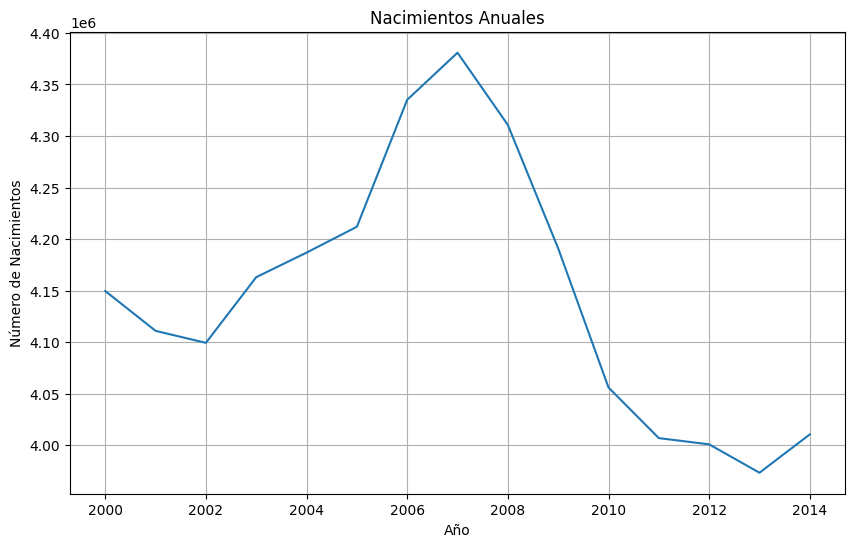

In [5]:

# Assuming that df_birth has a 'year' and 'births' column
df_annual_births = df_birth.groupby('year')['births'].sum()

# Create the line chart
plt.figure(figsize=(10, 6))
df_annual_births.plot(kind='line')
plt.title('Nacimientos Anuales')
plt.xlabel('Año')
plt.ylabel('Número de Nacimientos')
plt.grid(True)
plt.show()


In [6]:
df_with_dummies = pd.get_dummies(df_combined, columns=['Moon_Phase', 'day_of_week'])

# Add the births column if it is not already in the DataFrame
df_with_dummies['births'] = df_combined['births']

# Calculate the correlation matrix
corr_matrix = df_with_dummies.corr()

# View the correlation of each characteristic with the target variable 'births'.
correlations_with_births = corr_matrix['births']

# Show correlations with 'births'.
print(correlations_with_births)

year                       -0.166135
month                       0.240351
date_of_month               0.000671
births                      1.000000
Date                       -0.149800
Alignment                  -0.016276
Moon_Phase_First Quarter    0.003215
Moon_Phase_Full Moon        0.002359
Moon_Phase_Last Quarter    -0.010321
Moon_Phase_New Moon         0.004734
day_of_week_1              -0.163714
day_of_week_2               0.182070
day_of_week_3               0.071213
day_of_week_4               0.079901
day_of_week_5              -0.020613
day_of_week_6               0.177854
day_of_week_7              -0.326680
Name: births, dtype: float64


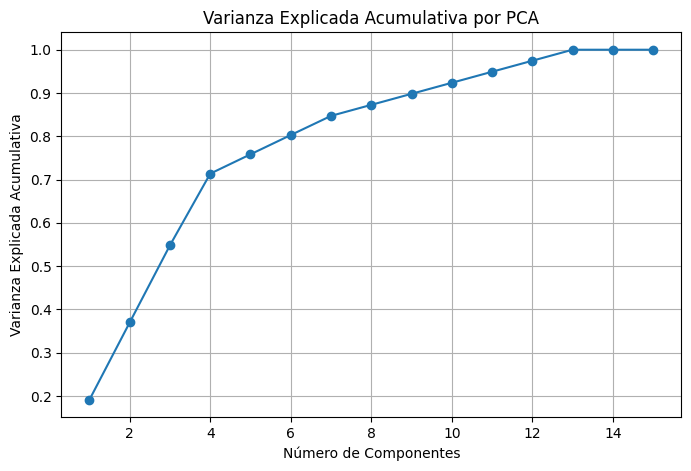

In [7]:


# List of categorical columns for one-hot encoding
categorical_columns = ['Moon_Phase', 'day_of_week']  

# List of numeric columns for standardization
numeric_columns = ['year', 'month', 'date_of_month', 'Alignment']  

# Prepare the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ]
)

# Apply the preprocessor and standardize the numerical characteristics
X = preprocessor.fit_transform(df_combined)

# Perform PCA with as many components as possible
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X)

# Calculate the cumulative explained variance
varianza_explicada_cumulativa = pca_full.explained_variance_ratio_.cumsum()

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(varianza_explicada_cumulativa) + 1), varianza_explicada_cumulativa, marker='o')
plt.title('Varianza Explicada Acumulativa por PCA')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulativa')
plt.grid(True)
plt.show()

In [8]:
# Run PCA with the number of components determined by the elbow method.
n_components_optimo = 4  
# Make sure that pca_optimum is the PCA object you used to transform the data.
pca_optimo = PCA(n_components=n_components_optimo)
X_pca_optimo = pca_optimo.fit_transform(X)

# Now you can access explained_variance_ and explained_variance_ratio_ in pca_optimum
explained_variance = pca_optimo.explained_variance_
explained_variance_ratio = pca_optimo.explained_variance_ratio_

# Print the explained variance and the proportion
for i, (var, ratio) in enumerate(zip(explained_variance, explained_variance_ratio)):
    print(f"Componente {i+1}: Varianza explicada = {var:.4f}, Proporción = {ratio:.4f}")

Componente 1: Varianza explicada = 1.0733, Proporción = 0.1914
Componente 2: Varianza explicada = 1.0012, Proporción = 0.1785
Componente 3: Varianza explicada = 0.9999, Proporción = 0.1783
Componente 4: Varianza explicada = 0.9281, Proporción = 0.1655


In [9]:
# Train a linear regression predictive model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data for model training
# We use 'year', 'month', 'date_of_month', 'day_of_week', and 'Daily Growth Rate' as features.
# X = df_combined_with_gdp[['year', 'month', 'date_of_month', 'day_of_week']]
X = df_combined[['year', 'month',  'day_of_week']]
y = df_combined['births']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display metrics
mse, r2

(656699.8681872337, 0.07801708548975528)

In [10]:
# Path to Excel file
file_path = './GBP_US.csv'

# Load the CSV file, indicating that there is no header and assign names to the columns.
df_gdp = pd.read_csv(file_path, delimiter=';', encoding='ISO-8859-1')
                    # , header=None
                    # , names=['Fecha', 'PIB Trimestral', 'Var. Trim. PIB (%)', 'Var. anual PIB Trim. (%)'])

def parse_trimester(trimester_str):
    """Convierte un string de trimestre 'I Trim 2000' a una fecha '2000-01-01'."""
    # It is assumed that the format is always '[Roman numeral] Trim [Year]' and that the fiscal year is the same as the calendar year.
    # and that the fiscal year is the same as the calendar year.
    trimester_mapping = {'I': '01-01', 'II': '04-01', 'III': '07-01', 'IV': '10-01'}
    parts = trimester_str.split()
    trimester = parts[0]
    year = parts[-1]
    return f"{year}-{trimester_mapping[trimester]}"




# Convert the column 'Date' to a real date
df_gdp['Fecha'] = df_gdp['Fecha'].apply(parse_trimester)

# Convert the quarterly growth percentage column to float
df_gdp['Var. Trim. PIB (%)'] = df_gdp['Var. Trim. PIB (%)'].str.replace(',', '.').str.rstrip('%').astype('float') / 100
df_gdp['Var. anual PIB Trim. (%)'] = df_gdp['Var. anual PIB Trim. (%)'].str.replace(',', '.').str.rstrip('%').astype('float') / 100
# Display the first few rows to verify that the load is correct
df_gdp.head()


# Create an empty list to store the daily data
daily_data = []

# Iterate through each row of the PIB DataFrame
for index, row in df_gdp.iterrows():
    # Obtener la fecha de inicio y fin del trimestre
    start_date = pd.to_datetime(row['Fecha'])
    end_date = start_date + pd.offsets.QuarterEnd()
    
    # Obtain the start and end date of the quarter
    num_days = (end_date - start_date).days + 1
    
    # Apportioning quarterly growth by day
    daily_growth = row['Var. Trim. PIB (%)'] / num_days
    
    # Create an entry for each day of the quarter
    for single_date in pd.date_range(start_date, periods=num_days, freq='D'):
        daily_data.append({
            'Fecha': single_date,
            'Crecimiento Diario (%)': daily_growth
        })

# Convertir la lista de datos diarios en un DataFrame
df_daily_growth = pd.DataFrame(daily_data)

# Convert the list of daily data into a DataFrame
df_daily_growth['Fecha'] = df_daily_growth['Fecha'].dt.strftime('%Y-%m-%d')

# Now df_daily_growth has the GDP growth spread by day.
df_daily_growth
# # Combinar con df_combined
# df_combined['Fecha'] = pd.to_datetime(df_combined['Fecha']).dt.strftime('%Y-%m-%d')
# df_combined = df_combined.merge(df_daily_growth, on='Fecha', how='left')

# # Verificar los resultados
# df_combined.head()

,Fecha,Crecimiento Diario (%)
0,2000-01-01,0.000044
1,2000-01-02,0.000044
2,2000-01-03,0.000044
3,2000-01-04,0.000044
4,2000-01-05,0.000044
...,...,...
5474,2014-12-27,0.000054
5475,2014-12-28,0.000054
5476,2014-12-29,0.000054
5477,2014-12-30,0.000054


In [11]:
######################################################################
######################################################################
##############################################################
# Reincorpore 4634 from 'births' only where the condition is met.
df_combined.loc[condition, 'births'] += 4634
##############################################################


file_path = './US_monthly_gdp.csv'

# Load the CSV file, indicating that there is no header and assign names to the columns.
df_gdp = pd.read_csv(file_path, encoding='ISO-8859-1', delimiter='|')#, delimiter=';', encoding='ISO-8859-1')


# Convert the column 'Date' to datetime
df_gdp['Fecha'] = pd.to_datetime(df_gdp['Fecha'], format='%Y - %b')
# Convert the Real GDP index column to float, replacing the commas and removing the currency.
df_gdp['Monthly Real GDP Index'] = df_gdp['Monthly Real GDP Index'] \
    .str.replace(',', '.') \
    .str.replace(' M€', '') \
    .astype(float)

# Calculate the monthly growth rate
df_gdp['Tasa de Crecimiento Mensual'] = df_gdp['Monthly Real GDP Index'].pct_change()
df_gdp.at[0, 'Tasa de Crecimiento Mensual'] = -0.0065855
# Generate a range of daily dates from start to finish
start_date = df_gdp['Fecha'].min()
end_date = df_gdp['Fecha'].max() + pd.offsets.MonthEnd(0)
daily_dates = pd.date_range(start_date, end_date)

# Initialize the DataFrame for the daily data
df_gdp_daily = pd.DataFrame(index=daily_dates)

# Assign the monthly growth rate to the first date of each month.
df_gdp_daily = df_gdp_daily.join(df_gdp.set_index('Fecha')['Tasa de Crecimiento Mensual'])

# Interpolate daily values
df_gdp_daily['Tasa de Crecimiento Diario'] = df_gdp_daily['Tasa de Crecimiento Mensual'].interpolate(method='linear')

# Reset the index to convert the dates back to a column
df_gdp_daily.reset_index(inplace=True)
df_gdp_daily.rename(columns={'index': 'Fecha'}, inplace=True)



# View the first records to confirm
df_gdp_daily.head()

# Combine with df_combined
# df_combined['Fecha'] = pd.to_datetime(df_combined['Fecha']).dt.strftime('%Y-%m-%d')
df_combined['Fecha'] = df_combined['Date']
df_combined = df_combined.merge(df_gdp_daily, on='Fecha', how='left')

# Verify the results
df_combined.head()


,year,month,date_of_month,day_of_week,births,Date,Alignment,Moon_Phase,Fecha,Tasa de Crecimiento Mensual,Tasa de Crecimiento Diario
0,2000,1,1,6,9083,2000-01-01,0,Last Quarter,2000-01-01,-0.006586,-0.006586
1,2000,1,2,7,8006,2000-01-02,0,Last Quarter,2000-01-02,NaN,-0.006235
2,2000,1,3,1,11363,2000-01-03,0,New Moon,2000-01-03,NaN,-0.005885
3,2000,1,4,2,13032,2000-01-04,0,New Moon,2000-01-04,NaN,-0.005534
4,2000,1,5,3,12558,2000-01-05,0,New Moon,2000-01-05,NaN,-0.005184


In [12]:
df_combined.drop(['Fecha', 'Tasa de Crecimiento Mensual'], axis = 1, inplace = True)
df_combined.head()

,year,month,date_of_month,day_of_week,births,Date,Alignment,Moon_Phase,Tasa de Crecimiento Diario
0,2000,1,1,6,9083,2000-01-01,0,Last Quarter,-0.006586
1,2000,1,2,7,8006,2000-01-02,0,Last Quarter,-0.006235
2,2000,1,3,1,11363,2000-01-03,0,New Moon,-0.005885
3,2000,1,4,2,13032,2000-01-04,0,New Moon,-0.005534
4,2000,1,5,3,12558,2000-01-05,0,New Moon,-0.005184


In [13]:
df_combined.to_csv('df_combined.csv', index = False , float_format='%.10f')
df_gdp.to_csv('df_gdp.csv', index = False,  float_format='%.10f')
df_gdp_daily.to_csv('us_monthly_gdp_normalized.csv', index = False, float_format='%.10f')
df_combined.to_csv('df_combined_gdp.csv', index = False, float_format='%.10f')

In [14]:
df_combined_with_gdp = pd.read_csv('df_combined_gdp.csv')

In [15]:
print(df_combined_with_gdp.loc[18:20, ['Date', 'Tasa de Crecimiento Diario']])

          Date  Tasa de Crecimiento Diario
18  2000-01-19                   -0.000277
19  2000-01-20                    0.000074
20  2000-01-21                    0.000424


In [16]:
# First, we will calculate the correlation matrix again with the updated DataFrame.

df_combined_with_gdp.drop(['Date'], axis = 1, inplace = True)
# df_combined_with_gdp['year'] = df_combined_with_gdp['year'].astype(float)
# df_combined_with_gdp['month'] = df_combined_with_gdp['month'].astype(float)
# df_combined_with_gdp['date_of_month'] = df_combined_with_gdp['date_of_month'].astype(float)
# df_combined_with_gdp['day_of_week'] = df_combined_with_gdp['day_of_week'].astype(float)
# df_combined_with_gdp['births'] = df_combined_with_gdp['births'].astype(float)
# df_combined_with_gdp['Alignment'] = df_combined_with_gdp['Alignment'].astype(float)

# # Calculate the correlation matrix
# correlation_matrix = df_combined_with_gdp.corr()
df_with_dummies = pd.get_dummies(df_combined_with_gdp, columns=['Moon_Phase', 'day_of_week'])

# Add the births column if it is not already in the DataFrame
df_with_dummies['births'] = df_combined_with_gdp['births']

# Calculate the correlation matrix
corr_matrix = df_with_dummies.corr()

# View the correlation of each characteristic with the target variable 'births'.
correlations_with_births = corr_matrix['births']

# Show correlations with 'births'.
print(correlations_with_births)





year                         -0.060479
month                         0.062425
date_of_month                -0.005275
births                        1.000000
Alignment                    -0.017001
Tasa de Crecimiento Diario   -0.014639
Moon_Phase_First Quarter      0.001467
Moon_Phase_Full Moon          0.000960
Moon_Phase_Last Quarter       0.000288
Moon_Phase_New Moon          -0.002714
day_of_week_1                 0.096177
day_of_week_2                 0.311197
day_of_week_3                 0.274031
day_of_week_4                 0.262433
day_of_week_5                 0.218629
day_of_week_6                -0.489434
day_of_week_7                -0.672776
Name: births, dtype: float64


In [17]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Assume df_combined_with_gdp is your DataFrame

# List of numeric features to normalize
# numeric_features = ['year', 'Tasa de Crecimiento Diario']
numeric_features = ['year', 'Tasa de Crecimiento Diario']
# List of categorical characteristics for applying one-hot encoding
categorical_features = ['month', 'day_of_week']#, 'Moon_Phase', 'Alignment']#, 'date_of_month', 'Alignment']

# Create transformers for numerical and categorical characteristics
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Create the ColumnTransformer that will apply the transformations.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply the transformations and prepare the data for the model
X = df_combined_with_gdp[numeric_features + categorical_features]
y = df_combined_with_gdp['births']

# Create a pipeline that includes the preprocessing and the model.
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', LinearRegression())])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

# Training the model
model_pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = model_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display metrics
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 727309.7635103408
R^2 Score: 0.8656258579473812


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Define categorical and numerical characteristics
numerical_features = ['year', 'Tasa de Crecimiento Diario']
# List of categorical characteristics for applying one-hot encoding
categorical_features = ['month', 'day_of_week']

# Prepare the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Create a pipeline with preprocessing and Lasso
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso(random_state=42))
])


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training the model
lasso_pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred_lasso = lasso_pipeline.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso con Normalización - Mean Squared Error:", mse_lasso)
print("Lasso con Normalización - R^2 Score:", r2_lasso)

Lasso con Normalización - Mean Squared Error: 633207.5867026655
Lasso con Normalización - R^2 Score: 0.8790418936965979


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Create a new pipeline including the Random Forest model instead of linear regression.
rf_model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('model', RandomForestRegressor(random_state=42))])

# Model training with Random Forest
rf_model_pipeline.fit(X_train, y_train)

# Evaluation of the model
y_pred_rf = rf_model_pipeline.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest - Mean Squared Error:", mse_rf)
print("Random Forest - R^2 Score:", r2_rf)

# Cross-validation with Random Forest
cv_scores_rf = cross_val_score(rf_model_pipeline, X, y, cv=7, scoring='r2')
cv_mean_rf = cv_scores_rf.mean()
cv_std_rf = cv_scores_rf.std()

print(f"Random Forest - CV R^2 Mean: {cv_mean_rf}, CV R^2 Std: {cv_std_rf}")

Random Forest - Mean Squared Error: 648354.9276644043
Random Forest - R^2 Score: 0.8802131615420652
Random Forest - CV R^2 Mean: 0.8457972857967498, CV R^2 Std: 0.024328788064046425


In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define a range of hyperparameters to be tested
param_grid = {
    'model__n_estimators': [100, 300, 500],
    'model__max_depth': [10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Create a grid search with cross validation
grid_search = GridSearchCV(rf_model_pipeline, param_grid, cv=5, scoring='r2', verbose=2, n_jobs=-1)

# Training using the grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluating the model with the best hyperparameters
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print("Random Forest con Mejores Hiperparámetros - Mean Squared Error:", mse_best_rf)
print("Random Forest con Mejores Hiperparámetros - R^2 Score:", r2_best_rf)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mejores hiperparámetros: {'model__max_depth': 30, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 500}
Random Forest con Mejores Hiperparámetros - Mean Squared Error: 613864.4603110661
Random Forest con Mejores Hiperparámetros - R^2 Score: 0.8865854491038734


In [20]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder



# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# Create the Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Training the model
gb_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = gb_model.predict(X_test)
# Error Cuadrático Medio Calcular
mse = mean_squared_error(y_test, y_pred)
# Calculate R^2 Score
r2 = r2_score(y_test, y_pred)

# Display metrics
print("Gradient Boosting - Mean Squared Error:", mse)
print("Gradient Boosting - R^2 Score:", r2)

Gradient Boosting - Mean Squared Error: 633532.8395978445
Gradient Boosting - R^2 Score: 0.880827514475231


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Create the Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Define a grid of hyperparameters to test
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

# Set up grid search
grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)

# Execute grid search
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluate with the best hyperparameters
best_gb_model = grid_search.best_estimator_
y_pred_best_gb = best_gb_model.predict(X_test)
mse_best_gb = mean_squared_error(y_test, y_pred_best_gb)
r2_best_gb = r2_score(y_test, y_pred_best_gb)

print("Gradient Boosting con Mejores Hiperparámetros - Mean Squared Error:", mse_best_gb)
print("Gradient Boosting con Mejores Hiperparámetros - R^2 Score:", r2_best_gb)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Gradient Boosting con Mejores Hiperparámetros - Mean Squared Error: 633915.0995529707
Gradient Boosting con Mejores Hiperparámetros - R^2 Score: 0.8807556083858831


In [22]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the model
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost - Mean Squared Error:", mse_xgb)
print("XGBoost - R^2 Score:", r2_xgb)

XGBoost - Mean Squared Error: 587640.7209155201
XGBoost - R^2 Score: 0.8877462773956242


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Configuring the hyperparameters grid for XGBoost
xgb_param_grid = {
    'xgbregressor__n_estimators': [100, 200, 300],
    'xgbregressor__learning_rate': [0.01, 0.1, 0.2],
    'xgbregressor__max_depth': [3, 4, 5],
    'xgbregressor__min_child_weight': [1, 2, 3],
    'xgbregressor__subsample': [0.7, 0.8, 0.9]
}

# Create the XGBoost pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgbregressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Perform grid search
xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
xgb_grid_search.fit(X_train, y_train)

# Results
print("Mejores hiperparámetros para XGBoost:", xgb_grid_search.best_params_)
# Obtain the best model from grid search
best_xgb_model = xgb_grid_search.best_estimator_

# Making predictions on the test set
y_pred_xgb = best_xgb_model.predict(X_test)

# Calcular el error cuadrático medio y Puntuación R^2
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost con Mejores Hiperparámetros - Mean Squared Error:", mse_xgb)
print("XGBoost con Mejores Hiperparámetros - R^2 Score:", r2_xgb)



Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejores hiperparámetros para XGBoost: {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 4, 'xgbregressor__min_child_weight': 3, 'xgbregressor__n_estimators': 100, 'xgbregressor__subsample': 0.7}
XGBoost con Mejores Hiperparámetros - Mean Squared Error: 498981.81685894914
XGBoost con Mejores Hiperparámetros - R^2 Score: 0.9046822923247274


In [24]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the model
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred_lgb = lgb_model.predict(X_test)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print("LightGBM - Mean Squared Error:", mse_lgb)
print("LightGBM - R^2 Score:", r2_lgb)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 3835, number of used features: 4
[LightGBM] [Info] Start training from score 11342.155150
LightGBM - Mean Squared Error: 514942.3336638936
LightGBM - R^2 Score: 0.9016334440024849


In [26]:
import lightgbm as lgb

# Configure the hyperparameters grid for LightGBM
lgb_param_grid = {
    'lgbmregressor__n_estimators': [100, 200, 300],
    'lgbmregressor__learning_rate': [0.01, 0.1, 0.2],
    'lgbmregressor__num_leaves': [31, 41, 51],
    'lgbmregressor__max_depth': [3, 4, 5],
    'lgbmregressor__subsample': [0.7, 0.8, 0.9]
}

# Create the LightGBM pipeline
lgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lgbmregressor', lgb.LGBMRegressor(random_state=42))
])

# Perform grid search
lgb_grid_search = GridSearchCV(lgb_pipeline, lgb_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
lgb_grid_search.fit(X_train, y_train)

# Results
print("Mejores hiperparámetros para LightGBM:", lgb_grid_search.best_params_)
best_lgb_model = lgb_grid_search.best_estimator_

# Making predictions on the test set
y_pred_lgb = best_lgb_model.predict(X_test)

# Calcular el error cuadrático medio y Puntuación R^2
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print("LightGBM con Mejores Hiperparámetros - Mean Squared Error:", mse_lgb)
print("LightGBM con Mejores Hiperparámetros - R^2 Score:", r2_lgb)



Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 309
[LightGBM] [Info] Number of data points in the train set: 3835, number of used features: 21
[LightGBM] [Info] Start training from score 11342.155150
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with